# Face Mask Image Detection

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os
import cv2
import glob
import torch
import shutil
import itertools
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from torch import nn
from torch import optim
from torchvision import transforms, datasets, models
from keras.models import Sequential
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Flatten, Dense, Conv2D, BatchNormalization, MaxPooling2D, Dropout
from tensorflow.keras.applications import EfficientNetB1, VGG19, ResNet50, InceptionV3, MobileNet, DenseNet201

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Displaying sample images

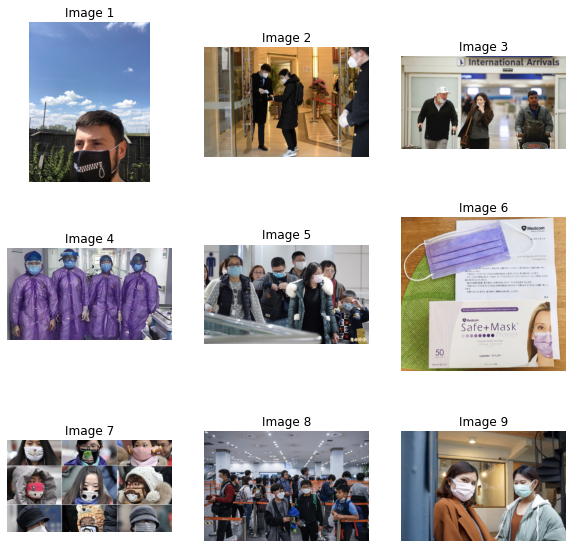

In [2]:
i = 0
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for dirname, _, filenames in os.walk('/kaggle/input/face-mask-detection'):
    for filename in filenames[:9]:
        img = cv2.imread(os.path.join(dirname, filename))
        if img is not None:
            img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            ax = list(axes.flatten())[i]
            ax.imshow(img)
            ax.set_title('Image ' + str(i+1))
            ax.axis('off')
            i += 1
plt.show()

In [3]:
images = []
augmented = []
path = '../input/face-mask-12k-images-dataset/Face Mask Dataset'

for set_ in os.listdir(path):
    i, j = 4, 4
    
    for img in os.listdir(path+'/'+set_+'/WithMask'):
        if img[0] != 'A':
            if i > 0:
                images.append(path+'/'+set_+'/WithMask/'+img)
                i -= 1
        else:
            if j > 0:
                augmented.append(path+'/'+set_+'/WithMask/'+img)
                j -= 1

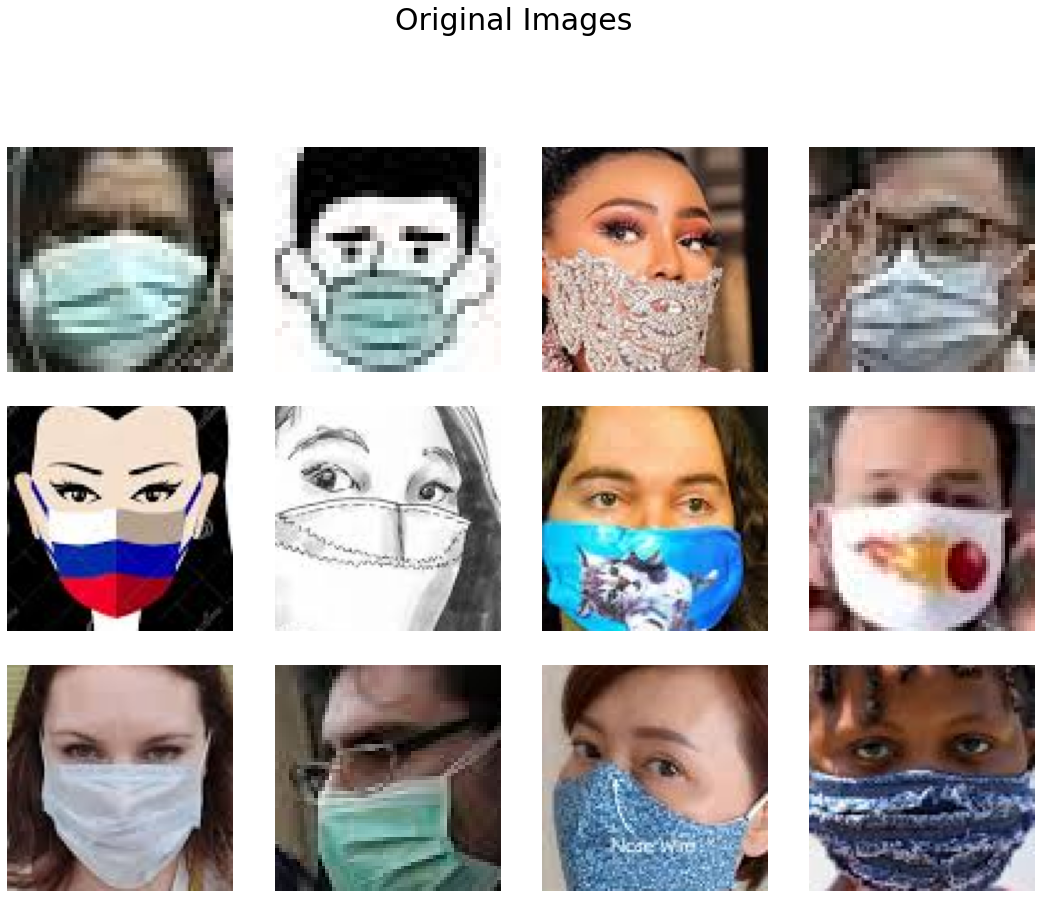

In [4]:
fig, axes = plt.subplots(3, 4, figsize=(15, 15))
fig.tight_layout()
fig.subplots_adjust(hspace=-0.5)

for ax in axes.flatten():
    ax = axes.flatten()[list(axes.flatten()).index(ax)]
    img = cv2.imread(images[list(axes.flatten()).index(ax)])
    img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    ax.imshow(img)
    ax.axis('off')

plt.suptitle('Original Images', size=30)
plt.show()

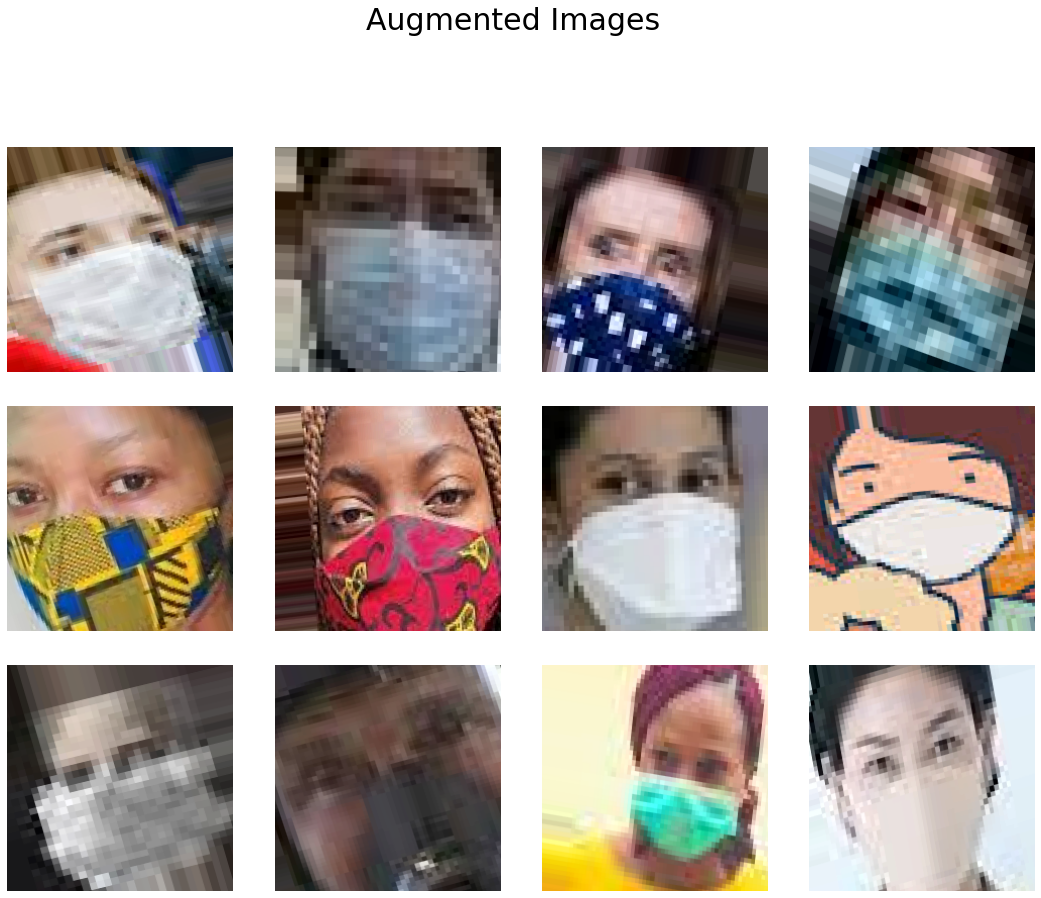

In [5]:
fig, axes = plt.subplots(3, 4, figsize=(15, 15))
fig.tight_layout()
fig.subplots_adjust(hspace=-0.5)

for ax in axes.flatten():
    ax = axes.flatten()[list(axes.flatten()).index(ax)]
    img = cv2.imread(augmented[list(axes.flatten()).index(ax)])
    img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    ax.imshow(img)
    ax.axis('off')

plt.suptitle('Augmented Images', size=30)
plt.show()

In [6]:
path, batch_size = '../input/withwithout-mask/maskdata/maskdata', 16

train_datagen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=True, zoom_range=0.2,
                                  shear_range=0.2)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(path+'/train', target_size=(128, 128), 
                                               batch_size=batch_size, class_mode='categorical')
test_generator = test_datagen.flow_from_directory(path+'/test', target_size=(128, 128), 
                                             batch_size=batch_size, class_mode='categorical')

Found 616 images belonging to 2 classes.
Found 198 images belonging to 2 classes.


# Distribution of classes

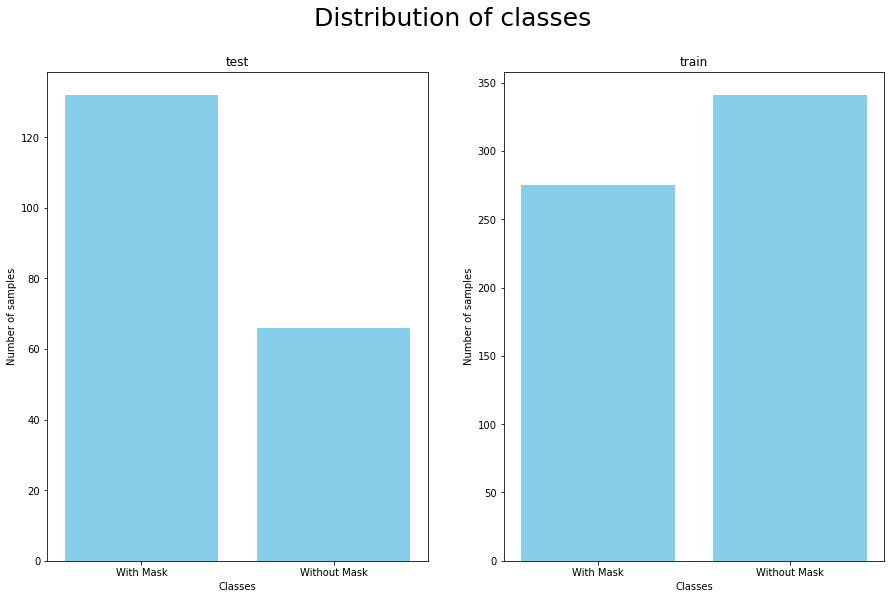

In [7]:
path = '../input/withwithout-mask/maskdata/maskdata'
fig, axes = plt.subplots(1, 2, figsize=(15, 9))

for set_ in os.listdir(path):
    counts = []
    ax = axes[os.listdir(path).index(set_)]
    for class_ in os.listdir(path+'/'+set_):
        count=len(os.listdir(path+'/'+set_+'/'+class_))
        counts.append(count)
    ax.bar(['With Mask', 'Without Mask'], counts, color='skyblue')
    ax.set_title(set_)
    ax.set_xlabel('Classes')
    ax.set_ylabel('Number of samples')

plt.suptitle('Distribution of classes', size=25)
plt.show()

# Datasets

### face mask lite dataset

In [8]:
## face-mask-lite datasets
batch_size = 16
path = "../input/face-mask-lite-dataset"
validation_path = "../input/withwithout-mask/maskdata/maskdata/test"

train_datagen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=False, zoom_range=0.3,
                                  shear_range=0.3, rotation_range=0.3)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(path, target_size=(128, 128), 
                                               batch_size=batch_size, class_mode='categorical')
test_generator = test_datagen.flow_from_directory(validation_path, target_size=(128, 128), 
                                             batch_size=batch_size, class_mode='categorical')

Found 20000 images belonging to 2 classes.
Found 198 images belonging to 2 classes.


### Covid face mask detection dataset

In [9]:
## Covid face mask detection dataset
batch_size = 16
path = "../input/covid-face-mask-detection-dataset/New Masks Dataset/Train"
validation_path = "../input/covid-face-mask-detection-dataset/New Masks Dataset/Test"

train_datagen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=False, zoom_range=0.3,
                                  shear_range=0.3)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(path, target_size=(128, 128), 
                                               batch_size=batch_size, class_mode='categorical')
test_generator = test_datagen.flow_from_directory(validation_path, target_size=(128, 128), 
                                             batch_size=batch_size, class_mode='categorical')

Found 600 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


### face-mask-12k-images-dataset

In [ ]:
batch_size = 16
path = "../input/face-mask-12k-images-dataset/Face Mask Dataset"

train_datagen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=True, zoom_range=0.2,
                                  shear_range=0.2)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(path+'/Train', target_size=(128, 128), 
                                               batch_size=batch_size, class_mode='categorical')
test_generator = test_datagen.flow_from_directory(path+'/Validation', target_size=(128, 128), 
                                             batch_size=batch_size, class_mode='categorical')

# Model define & Train

### Callbacks Define

In [10]:
import tensorflow as tf
batch_size = 16
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.00005)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

checkpoint_path = "training_12/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# 创建一个保存模型权重的回调
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

best_model_path = "training_12/best.h5"
best_model = tf.keras.callbacks.ModelCheckpoint(filepath=best_model_path, monitor='val_loss', verbose=0, 
                                save_best_only=True, save_weights_only=False, 
                                mode='min', period=1)

Callbacks = [reduce_lr,cp_callback, best_model]

In [11]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3), strides=2))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(2, activation='sigmoid'))
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 63, 63, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0         
_________________________________________________________________
dropout (Dropout)            (None, 12544)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                4

In [12]:
# BATCH_SIZE = 16 * tpu_strategy.num_replicas_in_sync
history = model.fit(train_generator,  
                    epochs=5,
                    validation_data=test_generator,
                    steps_per_epoch=len(train_generator), 
                    validation_steps=len(test_generator), 
                    callbacks=[Callbacks],
                    verbose=1)

Epoch 1/5
38/38 [==============================] - 18s 450ms/step - loss: 0.6945 - accuracy: 0.5995 - val_loss: 0.4225 - val_accuracy: 0.8200

Epoch 00001: saving model to training_12/cp.ckpt
Epoch 2/5
38/38 [==============================] - 10s 260ms/step - loss: 0.3639 - accuracy: 0.8368 - val_loss: 0.2406 - val_accuracy: 0.9300

Epoch 00002: saving model to training_12/cp.ckpt
Epoch 3/5
38/38 [==============================] - 10s 260ms/step - loss: 0.2254 - accuracy: 0.9246 - val_loss: 0.2916 - val_accuracy: 0.8300

Epoch 00003: saving model to training_12/cp.ckpt
Epoch 4/5
38/38 [==============================] - 10s 258ms/step - loss: 0.3133 - accuracy: 0.8709 - val_loss: 0.1847 - val_accuracy: 0.9500

Epoch 00004: saving model to training_12/cp.ckpt
Epoch 5/5
38/38 [==============================] - 10s 264ms/step - loss: 0.2597 - accuracy: 0.9252 - val_loss: 0.1716 - val_accuracy: 0.9600

Epoch 00005: saving model to training_12/cp.ckpt


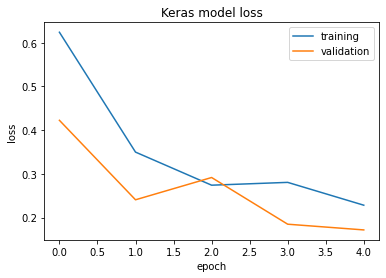

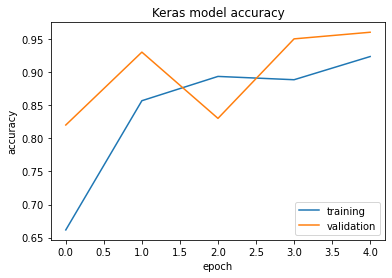

In [13]:
from matplotlib import pyplot as plt

# Visualize History for Loss.
plt.title('Keras model loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

# Visualize History for Accuracy.
plt.title('Keras model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc='lower right')
plt.show()

# Model Evaluate & Save

## Evaluate model

In [14]:
test_path = "../input/face-mask-12k-images-dataset/Face Mask Dataset/Test"
# best_model = tf.keras.models.load_model("training_2/best.h5")
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(test_path, target_size=(128, 128))

# best_model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')

# load best model
best_model = tf.keras.models.load_model("./training_12/best.h5")
# evaluate last model
scores = model.evaluate(test_generator, steps=1, verbose=1)
# evaluate best model
scores_best = best_model.evaluate(test_generator, steps=1, verbose=1)

Found 992 images belonging to 2 classes.
1/1 [==============================] - 0s 210ms/step - loss: 0.3699 - accuracy: 0.8438


## Save Model

In [ ]:
# convert to tflite model.
import tensorflow as tf
import os
from pathlib import Path

best_model.save("best.h5")
# # keras 模型转 tflite，后者模型会更小一点，算子支持更多
saved_model_dir = "./best.h5"
model = tf.keras.models.load_model(saved_model_dir)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

tflite_file = Path("./best.tflite")
tflite_file.write_bytes(tflite_model)